In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
#For geoplots
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

In [3]:
import numpy as np # linear algebra
import pandas as pd 

In [4]:
#Reading the dataset.
data = pd.read_csv("AB_NYC_2019.csv")

Let us explore the top 5 observation in the dataset to get a feel about what the data looks like and what are the columns we are dealing with.

In [3]:
#Exploring the top 5 observations.
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


We can see that there are some NaN values in the last_review and reviews_per_month columns. We will look into the null values in details later.

In [4]:
#describing the datasets.
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [5]:
data.shape

(48895, 16)

We can see that the price column has some irregularity as the minimum price of the apartment is 0 i.e Free stay?. We will have look deeper into this later.

In [5]:
#null or missing values in the dataset.
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Missing values are present in the name, host_name, last_reviews and reviews_per_month columns.<br>
In the above exploration part we can see that if the number_of_reviews is 0 then it does not make sense to have last_review and reviews_per_month and are marked as NaN.<br>
Hence the missing values in the data is following a pattern and will be treated accordingly.

Let us check if the assumption made above holds true.

In [6]:
#checking the assumption -> 0 reviews will have missing values in last_review and reviews_per_month columns.
assumption_test = data.loc[(data.last_review.isnull()) & (data.reviews_per_month.isnull()), ['number_of_reviews',  'last_reviews', 'reviews_per_month']]
assumption_test.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,number_of_reviews,last_reviews,reviews_per_month
2,0,NaN,NaN
19,0,NaN,NaN
26,0,NaN,NaN
36,0,NaN,NaN
38,0,NaN,NaN


As we can see our assumption holds true. Let us check the shape of the created dataframe and the number of null values.

In [7]:
assumption_test.shape

(10052, 3)

The exact amount of null values present in both the columns. It proves that the assumption madde was clear.<br>
We will substitute 0 for the missing values present in reviews_per_month column. <br>

As for the last_review column we know that it is a datetime object of the pandas and substituting 0 won't make sense here.<br>
We will have to leave the nul values of last_reviews as it is for now.

In [8]:
#filling the missing values in reviews_per_month with 0.
data.reviews_per_month.fillna(0, inplace=True)

In [9]:
#Checking if the changes made are reflected.
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

That been done, we will also leave the null values present in the host name and name columns as they are not required for our EDA as of now.<br>

# Exploratory Data Analysis

Lets begin with our exploratory data analysis.

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Name: neighbourhood, dtype: int64


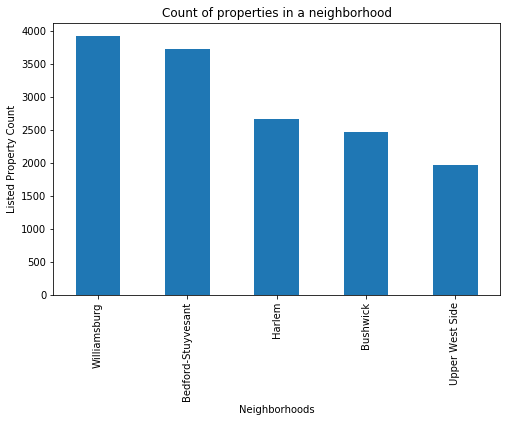

In [10]:
#checking the to 5 neighborhood where the properties are listed most.
top_5_neighborhoods = data.neighbourhood.value_counts().head(5)
print(top_5_neighborhoods)

#plotting 
plt.figure(figsize=(8,5))
top_5_neighborhoods.plot.bar()
plt.xlabel('Neighborhoods')
plt.ylabel('Listed Property Count')
plt.title('Count of properties in a neighborhood')
plt.show() #optional

The top 5 neighborhoods whcih have the highest number of properties listed are shown above.<br>
We can see that Williamsburg has the highest number of properties listed (3920) followed by Bedford-Stuyvesant (3714).

As Williamsburg has the highest number of properties listed then the Brooklyn neighborhood group must also have the highest number of properties listed as williamburg comes under brooklyn neighborhood group.

Lets check if this is correct or not.

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64


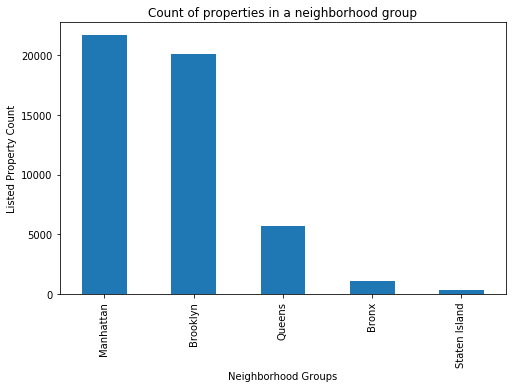

In [11]:
#checking the to 5 neighborhood groups where the properties are listed most.
top_5_neighborhood_group = data.neighbourhood_group.value_counts()
print(top_5_neighborhood_group)

#plotting 
plt.figure(figsize=(8,5))
top_5_neighborhood_group.plot.bar()
plt.xlabel('Neighborhood Groups')
plt.ylabel('Listed Property Count')
plt.title('Count of properties in a neighborhood group')
plt.show() #optional

Our assumption was wrong. As it turned out that Manhattan has the higghest number of properties listed although Williamsburg town in Brooklyn had the highest number of properties amongh the neighbor towns.

This infers that there are many other towns in Manhattan that have properties listed and that is why Manhattan neighborhood as a whole has the highest number of properties.

We can also see that other neighborhood groups such as Queens, Bronx and Staten Island contribute less compared to Manhattan and Brooklyn.

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64


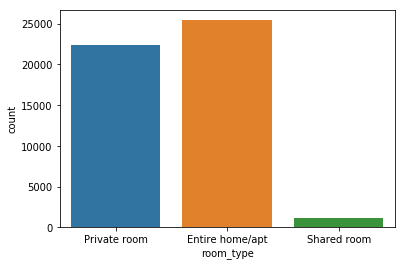

In [12]:
#number of rooms_type provided by the hosts
print(data.room_type.value_counts())
sns.countplot(data.room_type)

There are 3 room type provided by the host. Most of the rooms provided are private rooms and Entire home or apartments type.

Share rooms are listed very few, as it make sense that people travelling with family will prefer the top 2 room types rather than sharing.

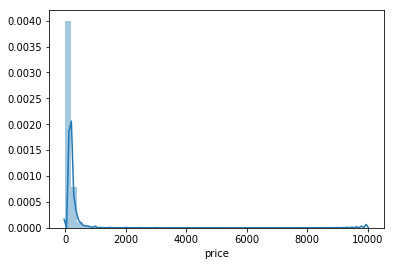

In [13]:
#Lets check the distribution of the price of the properties.
sns.distplot(data.price, bins=50)

The distribution of price is heavily left skewed. Meaning the most of the properties price are between 0 - 2000 and some minority of the properties are having prices grator than that making the data to be skewed.

Also we saw that some properties have a price as 0 and that could not be possible here as no one will be giving their property on rent for free! That will be absurd.

In [14]:
#Looking into the properties having 0 Price
free_properties = data.loc[data.price <= 0]
print('Shape of the data:', free_properties.shape)
free_properties.head()

Shape of the data: (11, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
25778,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73


11 properties have are having 0 price. Assuming this to be a mistake or error from the Airbnb side, we will have to impute the prices according. 

One way to impute will be by taking the mean, but as we saw earlier the price distribution is highly skewed and hence that will affect the mean of the price.

Presence of outliers or extreme values in the dataset effect the mean of the data and is not a good option to impute. Other method is to impute the data with mediian as median is less affected by outliers/extreme values.

The other effective way will be to see the affect of price or the relation of price on various other factors in the dataset and come up with a formula or a model that will do the imputation for us.<br>
We will look into this later.

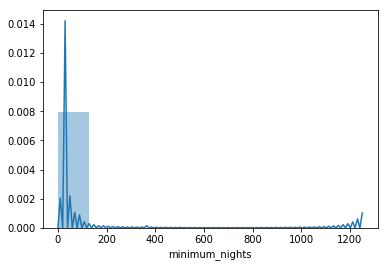

In [15]:
#minimum number of nights allowed by the host.
sns.distplot(data.minimum_nights, bins=10)

The minimum nights goes from 1 to 1200+. Only 1 host provide minimum_nights to be 1200+. We come to know from the distribution that the data is skewed.

Now let's check which top 5 properties have recieved the highest number of reviewes.

In [16]:
#properties recieving highest reviews.
highest_reviews = data.sort_values(by='number_of_reviews', ascending=False)
highest_reviews.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
11759,9145202,Room near JFK Queen Bed,47621202,Dona,Queens,Jamaica,40.66730,-73.76831,Private room,47,1,629,2019-07-05,14.58,2,333
2031,903972,Great Bedroom in Manhattan,4734398,Jj,Manhattan,Harlem,40.82085,-73.94025,Private room,49,1,607,2019-06-21,7.75,3,293
2030,903947,Beautiful Bedroom in Manhattan,4734398,Jj,Manhattan,Harlem,40.82124,-73.93838,Private room,49,1,597,2019-06-23,7.72,3,342
2015,891117,Private Bedroom in Manhattan,4734398,Jj,Manhattan,Harlem,40.82264,-73.94041,Private room,49,1,594,2019-06-15,7.57,3,339
13495,10101135,Room Near JFK Twin Beds,47621202,Dona,Queens,Jamaica,40.66939,-73.76975,Private room,47,1,576,2019-06-27,13.40,2,173


The above table shows the top 5 properties which have recieved the highest number of reviews. Out of the 5, three properties are from the Manhattan neighborhood group in Harlem. 

The top property which has recieved the most reviews is from Queens in the neighborhood of Jamica. The property having 5th highest review is also from Queens.

Let us look at these properties and try to come up with some hypothesis on why these properties have the highest reviews.
1. These properties are the most popular properties among the others and that is why they may be getting more bookings and hence more reviews.
2. They come from the same host i.e Dona and JJ. May be they are a good and popular hosts that is why are recieving good amount of bookings and reviews.
3. The Dona host has her room near the JFK i.e nearer to the international airport and that's why the high amount of bookings.
4. All of them share the similar room type, i.e Private rooms. So we can assume that the private rooms are more popular than any other rooms.
5. The price is also almost similar of all the properties approx 50.
6. They all offer minimum 1 night stay which most of the people prefer as it is very flexible.
7. The availability of the rooms is also high with the top 4 having an availability rate of approx 300 days and +.

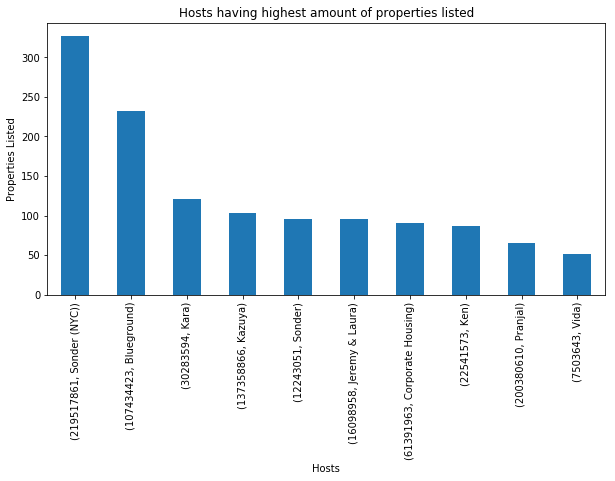

In [17]:
#host having highest amount of properties listed.
highest_props_host = data.groupby(['host_id', 'host_name'])['host_id'].count().sort_values(ascending=False)[:10]
highest_props_host.plot.bar(figsize=(10,5))
plt.xlabel('Hosts')
plt.ylabel('Properties Listed')
plt.title('Hosts having highest amount of properties listed');

We can see that Sonder(NYC) has the highest number of properties that are listed but his property was not in the top 5 highest reviews table we saw earlier.

This means that the number of properties listed on the Airbnb does not mean that the number of customers you will have will be more.

# Bivariate Analysis

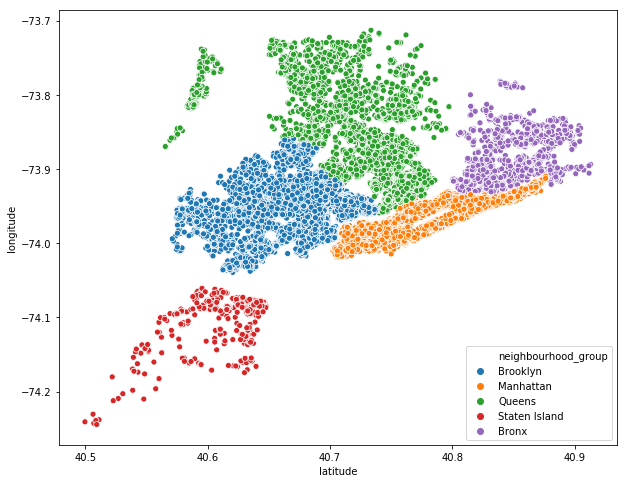

In [18]:
#neighborhood group based on the latitude and longitude
plt.figure(figsize=(10,8))
sns.scatterplot(data.latitude,data.longitude, hue='neighbourhood_group', data=data)

The above resemble the map of NYC and shows the various neighbourhoods and the properties listed in each neighbourhood.

In [19]:
# #Properties in the neighbourhood with most reviews. 
# plt.figure(figsize=(10,8))
# sns.scatterplot('latitude', 'longitude', hue='neighbourhood_group', data=highest_reviews.head(10))

# **Conclusion:**

So far we have done some basic exploring of the dataset and have gain few insights from it such as:
1. Came to know that the price column had some irregularities such as the minimum price was 0$ which is not possible.
2. Missing values in the last_review column and reviews_per_month column were following a pattern. If number_of_reviews was 0 then these two columns had null values.
3. From the univariate analysis we came to know the top 5 neighbourhood whcih had the highest number of properties listed.
4. We also came to know the top neighbourhood groups which had the highest number of properties listed.
5. We came to know the top 5 properties which had the highest review and factors contibuting to their reviews.
6. We came to know that properties closer to the airport had a good number of reviews.
7. We saw the host which had the highest number of properties listed on Airbnb.
8. We saw the distribution of the properties based on the neighbourhood_group on a scatter plot.